In [1]:
from pathlib import Path

import cv2
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import osmnx as ox
import yaml
from shapely import Point, Polygon

ox.settings.use_cache = True
ox.settings.log_console = False

with open("../plotting_config.yaml", "r") as fp:
    config = yaml.safe_load(fp)


def calculate_image_size(
    area_bounds: tuple[float, float, float, float], rx: int, ry: int
) -> tuple[float, float]:
    """
    area_bounds: (minx, miny, maxx, maxy)
    """
    width = (area_bounds[2] - area_bounds[0]) / rx
    height = (area_bounds[3] - area_bounds[1]) / ry
    return width, height


def plot_middle_japan(
    area,
    clipped: gpd.GeoDataFrame,
    fig_width: int,
    fig_height: int,
    crs: int,
    dpi: int = 100,
):
    fig = plt.figure(figsize=(fig_width, fig_height), dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1], frameon=False, xticks=[], yticks=[])
    gpd.GeoDataFrame(geometry=[area], crs=crs).plot(
        color="white", aspect=None, ax=ax, zorder=1
    )
    clipped.plot(color="#2d2d2d", aspect=None, ax=ax, zorder=5)
    selected_prefectures.plot(fc="none", ec="#ff557f", lw=2, ax=ax, zorder=10)
    ax.margins(0)
    ax.axis("off")
    ax.set_facecolor("white")
    fig.patch.set_visible(False)

    return fig, ax


def calculate_top_left_coordinates(area: Polygon, MPx: int, MPy: int, rx: int, ry: int):
    return area.bounds[0] + MPx * rx, area.bounds[3] - MPy * ry


def generate_grid_bottom_left(
    startx: float, starty: float, stepx: float = 500, stepy: float = 500
):
    grid = []
    x = []
    y = []
    # offsetx = 200*stepx
    offsety = 200 * stepy
    for j in range(200):
        for i in range(200):
            p = Polygon(
                [
                    Point(startx + (i * stepx), starty - offsety + (j * stepy)),
                    Point(startx + stepx + (i * stepx), starty - offsety + (j * stepy)),
                    Point(
                        startx + stepx + (i * stepx),
                        starty - offsety + stepy + (j * stepy),
                    ),
                    Point(startx + (i * stepx), starty - offsety + stepy + (j * stepy)),
                ]
            )
            grid.append(p)
            x.append(i + 1)
            y.append(j + 1)
    return gpd.GeoDataFrame(
        {"geometry": grid, "y": x, "x": y}, geometry="geometry", crs=CRS
    )

In [2]:
CRS = 2449  # Japan Plane Rectangular CS VII

rx = 4000
ry = 4000
version = ""
version = "_v2"
STRETCH = True

In [3]:
stretch_suffix = "unstretched"
if STRETCH:
    stretch_suffix = ""
path = f"../figures/rescaled/{stretch_suffix}"
Path(path).mkdir(parents=True, exist_ok=True)

In [4]:
selected_prefectures = gpd.read_file(
    "../data/geojson/admin4_selected.geojson",
    crs=4326,
)

# Convert to meter-unit projection
selected_prefectures.to_crs(CRS, inplace=True)

In [5]:
coastlines = gpd.read_file("../data/geojson/japan_coastlines.geojson", engine="pyogrio")
coastlines.to_crs(CRS, inplace=True)

In [6]:
clipped = gpd.clip(coastlines, selected_prefectures.unary_union.envelope)

In [7]:
area = selected_prefectures.unary_union.envelope
area = Polygon(
    [(round(i[0] / rx) * rx, round(i[1] / ry) * ry) for i in area.boundary.coords]
)

In [8]:
print(f"bounds: {area.bounds}")
W, H = calculate_image_size(area.bounds, rx, ry)
print(f"width: {W}, height: {H}")

bounds: (-128000.0, -264000.0, 204000.0, 116000.0)
width: 83.0, height: 95.0


In [9]:
# stretch
if STRETCH:
    W = round(W * 1.1)
    H = round(H * 0.9)
print(f"width: {W}, height: {H}")

width: 91, height: 86


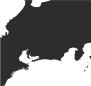

In [10]:
fig = plt.figure(figsize=(W, H), dpi=1)
ax = fig.add_axes([0, 0, 1, 1], frameon=False, xticks=[], yticks=[])
gpd.GeoDataFrame(geometry=[area], crs=CRS).plot(
    color="white", aspect=None, ax=ax, zorder=1
)
clipped.plot(color="#2d2d2d", aspect=None, ax=ax, zorder=5)
ax.margins(0)
ax.axis("off")
ax.set_facecolor("white")
fig.patch.set_visible(False)

fig.savefig(
    f"{path}/large_{rx}_{ry}.png",
    facecolor="white",
    pad_inches=0,
    metadata=config["metadata"],
)

In [11]:
img_scale_w = 100000 / rx
img_scale_h = 100000 / ry

(19, 40)


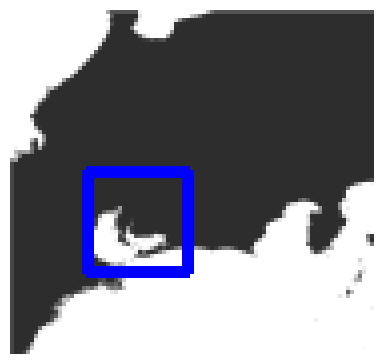

In [12]:
# based on https://stackoverflow.com/a/18075751/4737417
large_image = cv2.imread(f"{path}/large_{rx}_{ry}.png")
small_image = cv2.imread(f"{path}/activity_binary_{rx}_{ry}{version}.png")

bg = large_image.copy()
method = cv2.TM_SQDIFF_NORMED
result = cv2.matchTemplate(small_image, bg, method)

# We want the minimum squared difference
min_val, _, min_loc, max_loc = cv2.minMaxLoc(result)
rows, cols = small_image.shape[:2]

# Draw the rectangle:
# Extract the coordinates of our best match
if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
    top_left = min_loc
else:
    top_left = max_loc
bottom_right = (top_left[0] + rows, top_left[1] + cols)
print(top_left)

# Step 2: Get the size of the template. This is the same size as the match.
trows, tcols = small_image.shape[:2]

# Step 3: Draw the rectangle on large_image
cv2.rectangle(bg, top_left, bottom_right, (0, 0, 255), 2)


fig2 = plt.figure(figsize=(W / img_scale_w, H / img_scale_h), dpi=100)
ax2 = fig2.add_axes([0, 0, 1, 1], frameon=False, xticks=[], yticks=[])
ax2.imshow(bg)
ax2.axis("off")
ax2.margins(0)
fig2.patch.set_visible(False)
fig2.savefig(
    f"{path}/location_{rx}_{ry}{version}.png",
    facecolor="white",
    pad_inches=0,
    metadata=config["metadata"],
)

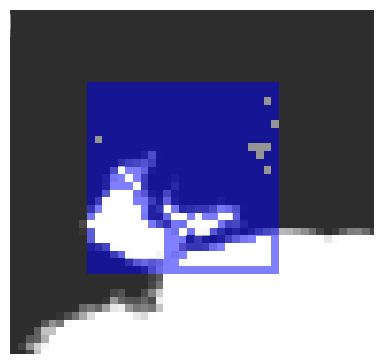

In [13]:
transform = mpl.transforms.Affine2D().translate(*top_left)
large_image = plt.imread(f"{path}/large_{rx}_{ry}.png")
binary = plt.imread(f"{path}/activity_binary_{rx}_{ry}{version}_blue.png")
fig_blue_z = plt.figure(figsize=(W / img_scale_w, H / img_scale_h), dpi=100)
ax_blue_z = fig_blue_z.add_axes([0, 0, 1, 1], frameon=False, xticks=[], yticks=[])
ax_blue_z.imshow(large_image, alpha=1, zorder=0)
b = ax_blue_z.imshow(binary, alpha=0.5, zorder=1)
b.set_transform(transform + ax_blue_z.transData)
ax_blue_z.axis("off")
ax_blue_z.margins(0)

xlim_4kv2 = [top_left[0] - (10 * W / H), top_left[0] + ((img_scale_w + 10) * W / H)]
ylim_4kv2 = [top_left[1] + img_scale_h + 10, top_left[1] - 10]
if rx == 4000 and version == "":
    xlim_4kv2 = [8.418604651162791, 56.03488372093023]
    ylim_4kv2 = [75.0, 30]
ax_blue_z.set_xlim(xlim_4kv2)
ax_blue_z.set_ylim(ylim_4kv2)

fig_blue_z.patch.set_visible(False)
for i in ["png"]:
    fig_blue_z.savefig(
        f"{path}/template_matched_zoomed_{rx}_{ry}{version}.{i}",
        facecolor="white",
        pad_inches=0,
        metadata=config["metadata"],
    )

In [14]:
startx, starty = calculate_top_left_coordinates(area, *top_left, rx, ry)
if STRETCH:
    startx, starty = calculate_top_left_coordinates(area, *top_left, rx / 1.1, ry / 0.9)

print(startx, starty)

with open(f"../output/anchor_{rx}_{ry}{version}.yaml", "w") as fp:
    yaml.dump({"top_left": {"x": round(startx, 3), "y": round(starty, 3)}}, fp)

-58909.09090909091 -61777.77777777778
